# Estimating Covariance and Expected Returns

CapWeighted portfolios are the overall average and hence the de-facto industry standard. They are very inexpensive to implement and feature very low turnover. 

EW are the most obvious improvement because they require no estimation of either covariance or expected returns.

In [6]:
import numpy as np
import pandas as pd

import edhec_risk_kit_205 as erk

%load_ext autoreload
%autoreload 2
inds = ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth',
       'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry',
       'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper',
       'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']
#inds=['Beer', 'Hlth', 'Fin','Rtail','Whlsl']
ind_rets = erk.get_ind_returns(weighting="ew", n_inds=49)["1974":]
ind_mcap = erk.get_ind_market_caps(49, weights=True)["1974":]

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.59806
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.58785


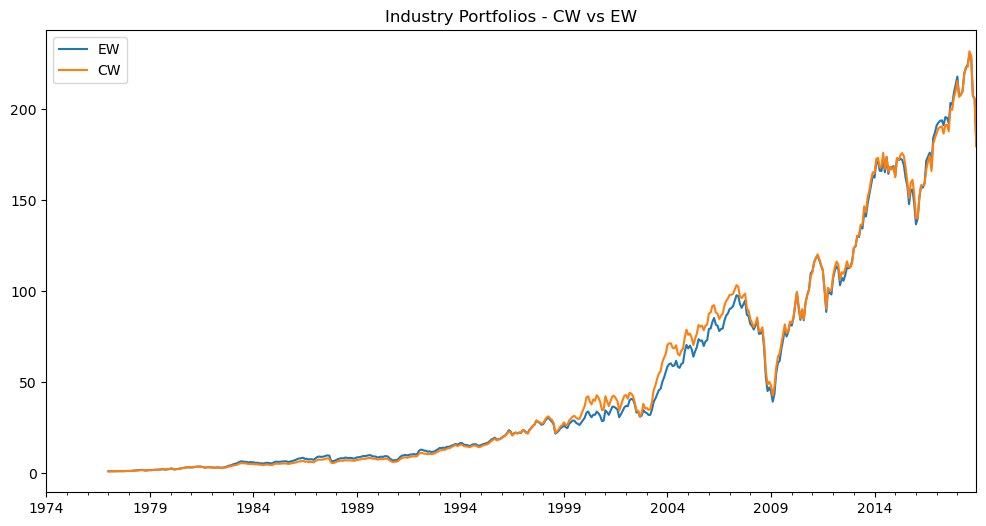

In [8]:
ewr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(ind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=ind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())

# Building the Global Minimum Variance Portfolio

In [11]:
def sample_cov(r, **kwargs):
    """
    Returns the sample covariance of the supplied returns
    """
    return r.cov()

def weight_gmv(r, cov_estimator=sample_cov, **kwargs):
    """
    Produces the weights of the GMV portfolio given a covariance matrix of the returns 
    """
    est_cov = cov_estimator(r, **kwargs)
    return erk.gmv(est_cov)


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.59806
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.58785
GMV-Sample,0.153095,0.116303,-0.811385,6.408552,0.047674,0.072557,1.030075,-0.46391


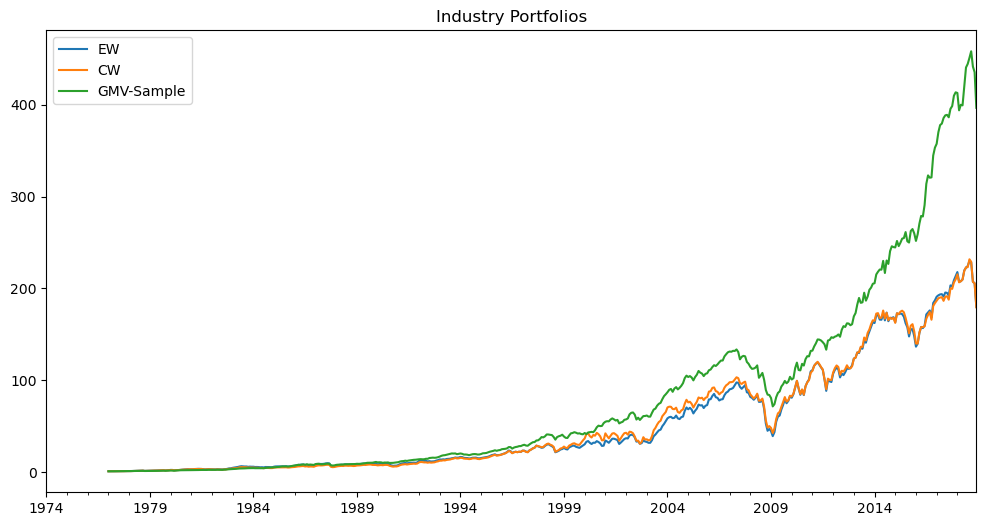

In [14]:
mv_s_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=sample_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

We can try a new estimator - Constant Correlation. The idea is simple, take the sample correlation matrix, compute the average correlation and then reconstruct the covariance matrix. The relation between correlations $\rho$ and covariance $\sigma$ is given by:

$$ \rho_{ij} = \frac{ \sigma_{ij} } { \sqrt{ \sigma_{ii}  \sigma_{jj} } } $$


In [17]:
#import statsmodels.stats.moment_helpers as mh
def cc_cov(r, **kwargs):
    """
    Estimates a covariance matrix by using the Elton/Gruber Constant Correlation model
    """
    rhos = r.corr()
    n = rhos.shape[0]
    # this is a symmetric matrix with diagonals all 1 - so the mean correlation is ...
    rho_bar = (rhos.values.sum()-n)/(n*(n-1))
    ccor = np.full_like(rhos, rho_bar)
    np.fill_diagonal(ccor, 1.)
    sd = r.std()
    ccov = ccor * np.outer(sd, sd)
#     mh.corr2cov(ccor, sd)
    return pd.DataFrame(ccov, index=r.columns, columns=r.columns)

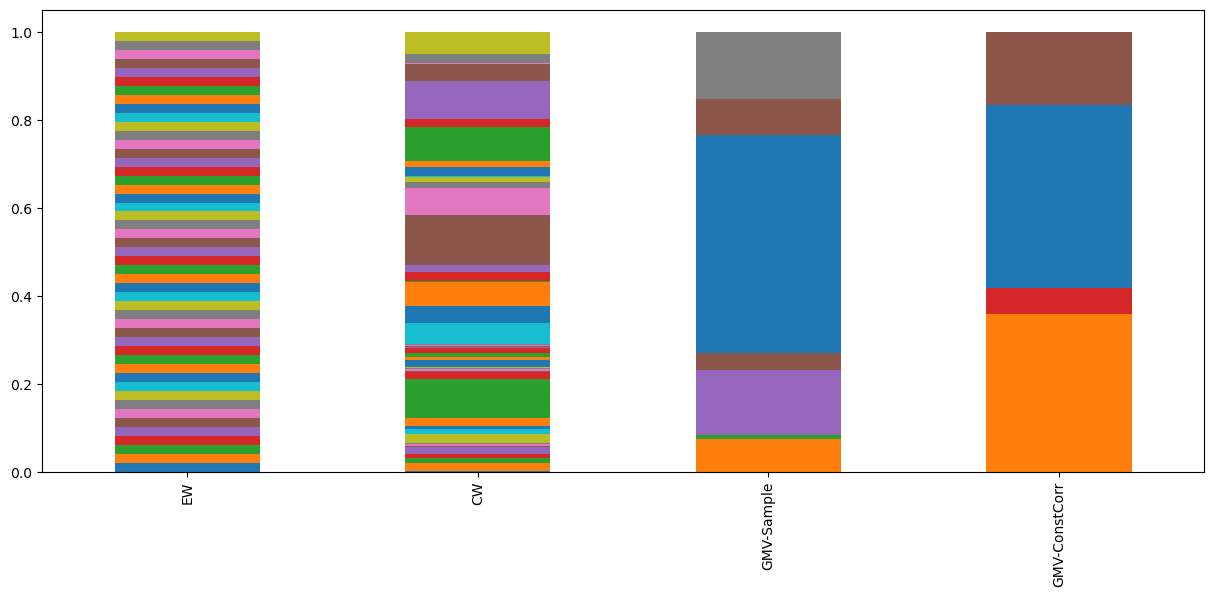

In [23]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2016":]),
    "CW": erk.weight_cw(ind_rets["2016":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2016":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2016":], cov_estimator=cc_cov),
})
wts.T.plot.bar(stacked=True, figsize=(15,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153095,0.116303,-0.811385,6.408552,0.047674,0.072557,1.030075,-0.463910
GMV-CC,0.132376,0.115347,-0.890915,6.072243,0.049608,0.075267,0.863754,-0.524088


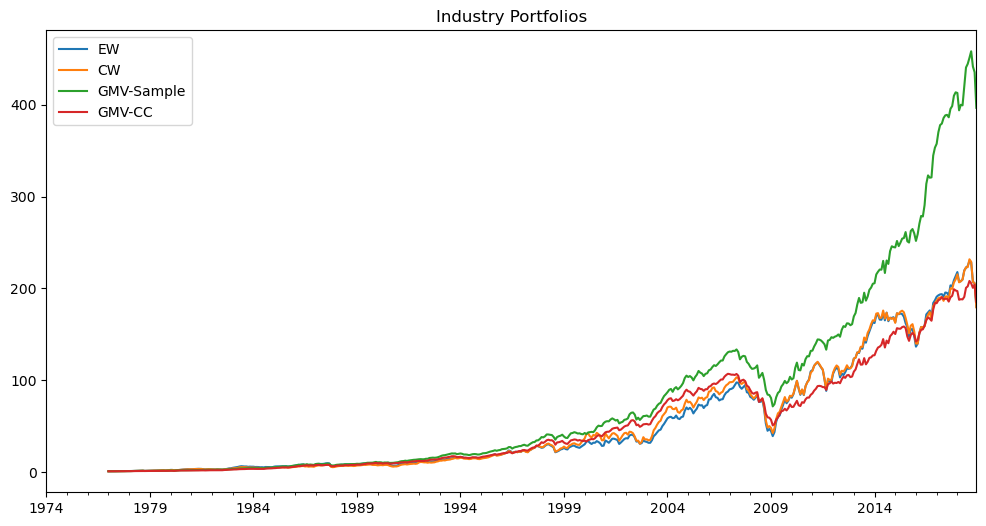

In [25]:
mv_cc_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=cc_cov)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios")
erk.summary_stats(btr.dropna())

### Statistical Shrinkage

We can mix the model and sample estimates by choosing a shrinkage parameter. You can either let the numbers dictate an optimal shrinkage value for $\delta$. Many practiotioners choose $0.5$. We can implement a simple shrinkage based covariance estimator that shrinks towards the Constant Correlation estimate:

In [28]:
def shrinkage_cov(r, delta=0.5, **kwargs):
    """
    Covariance estimator that shrinks between the Sample Covariance and the Constant Correlation Estimators
    """
    prior = cc_cov(r, **kwargs)
    sample = sample_cov(r, **kwargs)
    return delta*prior + (1-delta)*sample


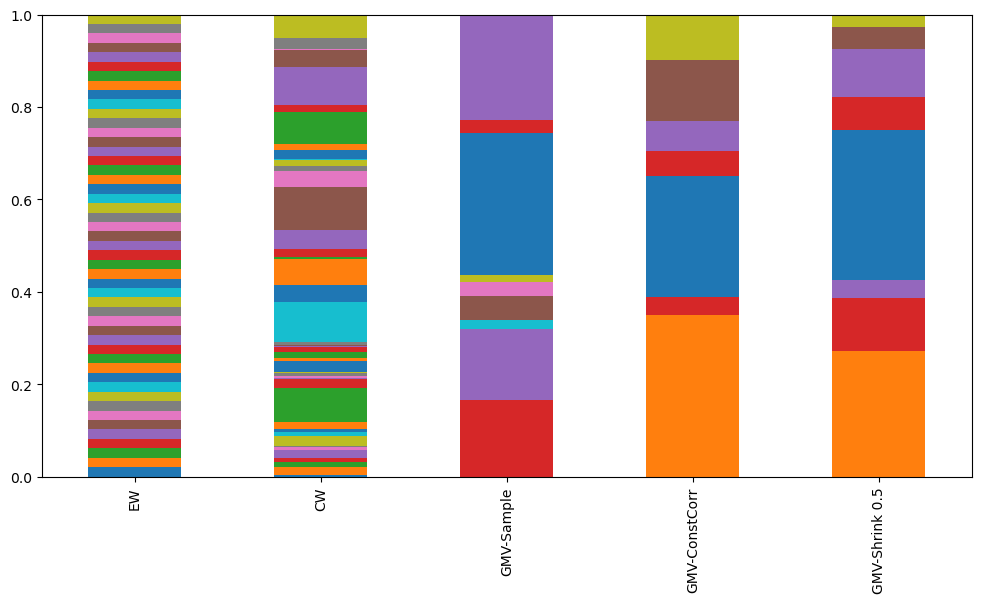

In [30]:
wts = pd.DataFrame({
    "EW": erk.weight_ew(ind_rets["2013":]),
    "CW": erk.weight_cw(ind_rets["2013":], cap_weights=ind_mcap),
    "GMV-Sample": weight_gmv(ind_rets["2013":], cov_estimator=sample_cov),
    "GMV-ConstCorr": weight_gmv(ind_rets["2013":], cov_estimator=cc_cov),
    "GMV-Shrink 0.5": weight_gmv(ind_rets["2013":], cov_estimator=shrinkage_cov),
})
wts.T.plot.bar(stacked=True, figsize=(12,6), legend=False);


,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.131606,0.187437,-0.616296,6.771301,0.082035,0.122226,0.527384,-0.598060
CW,0.131522,0.187236,-0.544912,5.820495,0.081975,0.120151,0.527515,-0.587850
GMV-Sample,0.153092,0.116303,-0.811382,6.408558,0.047674,0.072557,1.030056,-0.463911
GMV-CC,0.132374,0.115348,-0.890878,6.072177,0.049608,0.075267,0.863735,-0.524105
GMV-Shrink 0.5,0.138503,0.114873,-0.886390,6.305999,0.048716,0.074239,0.919243,-0.518470


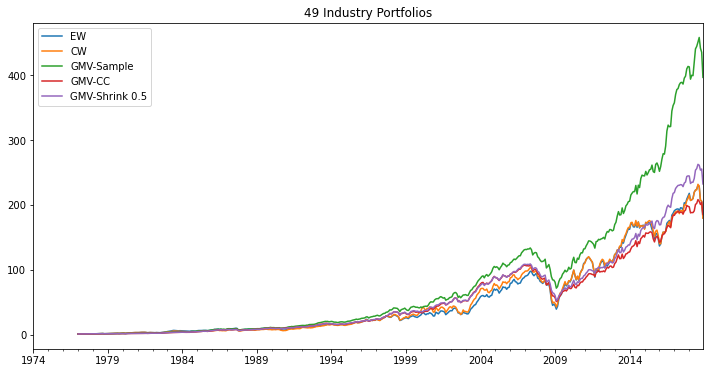

In [9]:
mv_sh_r = erk.backtest_ws(ind_rets, estimation_window=36, weighting=weight_gmv, cov_estimator=shrinkage_cov, delta=0.5)
btr = pd.DataFrame({"EW": ewr, "CW": cwr, "GMV-Sample": mv_s_r, "GMV-CC": mv_cc_r, 'GMV-Shrink 0.5': mv_sh_r})
(1+btr).cumprod().plot(figsize=(12,6), title="49 Industry Portfolios")
erk.summary_stats(btr.dropna())

# Conclusion

We see far superior compounded returns historically from deploying the GMV portfolio using the sample estimate for the covariance. 